In [2]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.compressed_sensing.CompressedSensing import perform_POD, perform_CS

import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import datetime
import itertools
import pandas as pd

Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (228, 85, 121)
Shape of input data: (10285, 228) [flattened space x time snapshots]
(10285, 228)


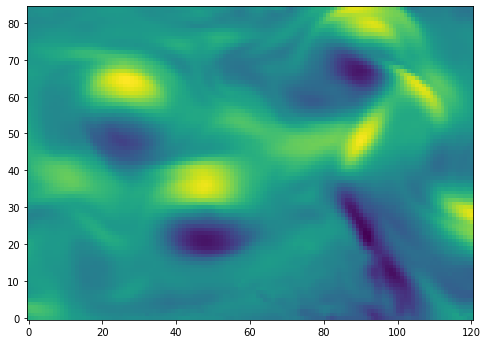

In [2]:
# set area
area="GoM"
if area == "area1":
    # Area 1
    data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
    files = os.listdir(data_dir)
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-140, -120), latitude=slice(15,32))
elif area == "GoM":
    # GoM
    data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/GoM"
    files = os.listdir(data_dir)
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-95, -85), latitude=slice(22,29))
else:
    print("Area name is invalid!")
    data = None

modes, eigvals, proj_coeffs, data, orig_data_shape = perform_POD(data, "utotal", 6)

# plot one snapshot
fig = plt.figure(figsize=(8, 8))
print(data.shape)
plt.imshow(data[:, 0].reshape(orig_data_shape[1:]), origin="lower")

In [3]:
# save all frames of original data to make gif
for i in range(data.shape[1]):
    plt.imsave(f"/home/jonas/Downloads/plots/data_gif/{str(i).zfill(4)}.png", data[:, i].reshape(orig_data_shape[1:]), origin="lower")

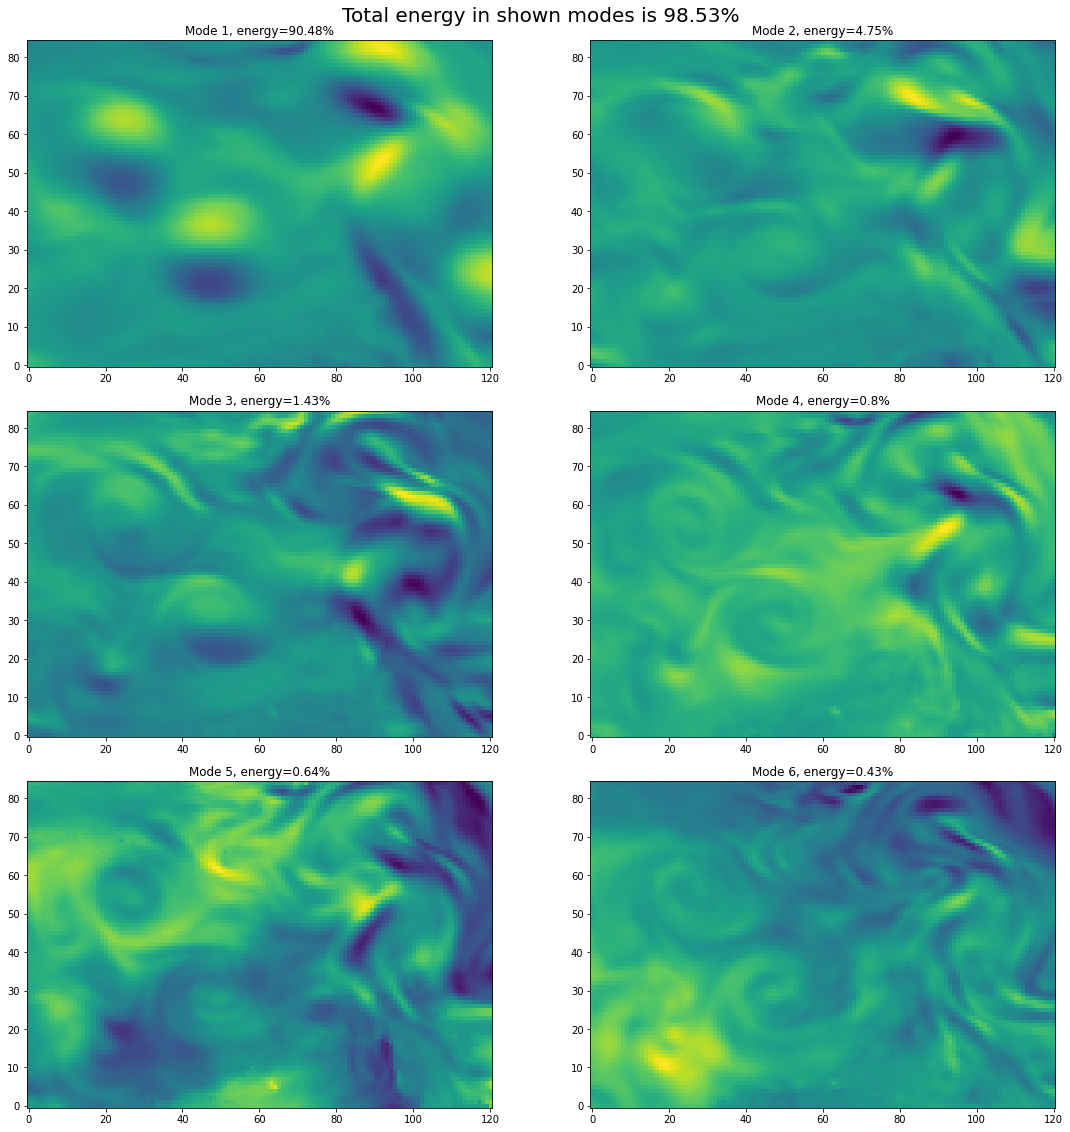

In [4]:
sum_eigvals = eigvals.sum()
normalized_eigvals = eigvals/sum_eigvals

fig, axs = plt.subplots(int(modes.shape[1]/2), 2, figsize=(16, 16))
for i in range(modes.shape[1]):
    ax = axs[int(i//2), i%2]
    ax.imshow(modes[:, i].reshape(orig_data_shape[1:]), origin="lower")
    ax.set_title(f"Mode {i+1}, energy={round(normalized_eigvals[i]*100, 2)}%")
fig.suptitle(f"Total energy in shown modes is {round(normalized_eigvals[:modes.shape[1]].sum()*100, 2)}%", fontsize=20)
plt.tight_layout()
plt.show()

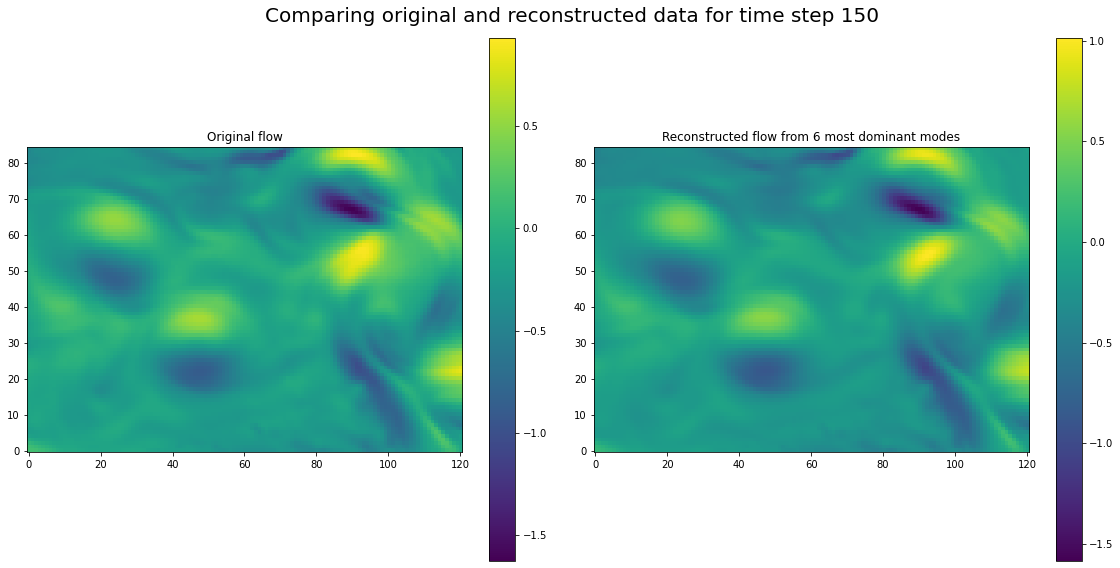

In [5]:
time_step = 150

# plot original data
fig, axs = plt.subplots(1, 2, figsize=(16,8))
img1 = axs[0].imshow(data[:, time_step].reshape(orig_data_shape[1:]), origin="lower")
axs[0].set_title("Original flow")
plt.colorbar(img1, ax=axs[0])

# proj coeffs are of shape [mode x time] -> whole column for first time step
reconstructed_currents = np.zeros_like(modes[:, 0])
for i in range(modes.shape[1]):
    scaling = proj_coeffs[i, time_step]
    reconstructed_currents += modes[:, i] * scaling

# plot reconstruction
img2 = axs[1].imshow(reconstructed_currents.reshape(orig_data_shape[1:]), origin="lower")
axs[1].set_title("Reconstructed flow from 6 most dominant modes")
plt.colorbar(img2, ax=axs[1])

fig.suptitle(f"Comparing original and reconstructed data for time step {time_step}", fontsize=20)
plt.tight_layout()
plt.show()

## Try compressed sensing with forecast first

##### Compressed sensing optimization

$$ \min_s || C\Psi s - y ||_2 + \lambda ||s||_1 $$

$$ x = \Psi s $$

where C is the sampling matrix and Psi is the linear transformation that maps from the sample domain to the domain the original signal can be represented in sparsely.

Loaded 97 days or forecasts
Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (2328, 121, 241)
Shape of input data: (29161, 2328) [flattened space x time snapshots]
Number of modes used: 200.
Number of measurements: 29.


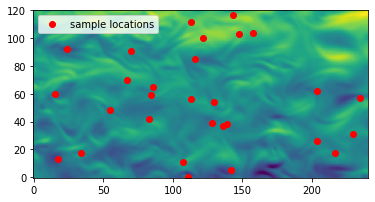

In [71]:
from ocean_navigation_simulator.generative_error_model.compressed_sensing.CompressedSensing import perform_POD

data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecasts/area1"
files = sorted(os.listdir(data_dir))

load_all_data = True

if load_all_data:
    # load all forecasts for area 1
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-140, -120),
                                                                 latitude=slice(20, 30))
    if len(files) > 1:
        data = data.isel(time=slice(0, 24))
        for file in range(1, len(files)):
            data_temp = xr.open_dataset(os.path.join(data_dir, files[file])).sel(longitude=slice(-140, -120), latitude=slice(20,30))
            data = xr.concat([data, data_temp.isel(time=slice(0, 24))], dim="time")

    print(f"Loaded {round(len(data['time'])/24)} days or forecasts")

else:
    # load one forecast for area 1
    data = xr.open_dataset(os.path.join(data_dir, files[0])).sel(longitude=slice(-140, -120), latitude=slice(20,30))

# get most dominant modes from FC
num_modes = data["utotal"].values.shape[0]
num_modes = 200
modes, eigvals, proj_coeffs, data, orig_data_shape = perform_POD(data, "utotal", num_modes)
print(f"Number of modes used: {num_modes}.")

# sample from forecast frame
fc_frame = data[:, 0].reshape(orig_data_shape[1:])

# sample from fc frame and get sample vector y
np.random.seed(12345678)
num_samples = int(0.001 * np.prod(fc_frame.shape))
print(f"Number of measurements: {num_samples}.")
samples_idx = np.random.choice(np.prod(fc_frame.shape), num_samples, replace=False)
y = fc_frame.flat[samples_idx]

# plot fc frame and samples
plt.imshow(fc_frame, origin="lower")
plt.scatter(samples_idx%orig_data_shape[2], samples_idx//orig_data_shape[2], color="r", label="sample locations")
plt.legend()
plt.show()

# Set Psi
Psi = modes

# setup C
C = np.zeros((num_samples, np.prod(fc_frame.shape)))
one_indices = np.array([[row, col] for row, col in zip(range(num_samples), samples_idx)])
C[one_indices[:, 0], one_indices[:, 1]] = 1

# construct A matrix
A = C @ Psi

# perform CS
vx = cvx.Variable(A.shape[-1])
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A @ vx == y]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=False)
basis_coeffs = np.array(vx.value)

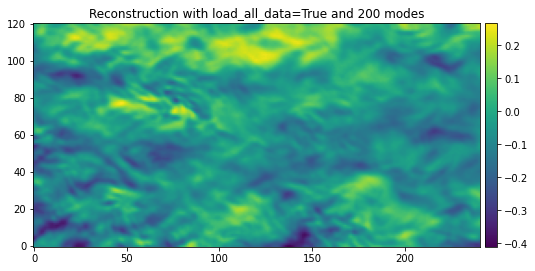

In [72]:
reconstructed_fc = np.dot(Psi, basis_coeffs)
reconstructed_fc = reconstructed_fc.reshape(orig_data_shape[1:])

fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
plt.title(f"Reconstruction with load_all_data={load_all_data} and {num_modes} modes")
img = ax.imshow(reconstructed_fc, origin="lower")
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(img, cax=cax)
plt.show()

In [60]:
# compute RMSE between real and reconstructed
error = fc_frame.reshape(orig_data_shape[1:]) - reconstructed_fc
rmse = np.sqrt((error**2).mean())
print(f"RMSE: {round(rmse, 4)}.")

RMSE: 0.1219.


## Try compressed sensing with buoy values

In [9]:
from ocean_navigation_simulator.generative_error_model.compressed_sensing.CompressedSensing import CompressedSensing, vis_reconstructed_and_forecast

data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data"
forecast_dir = os.path.join(data_dir, "forecasts/area1")
buoy_data_dir = os.path.join(data_dir, "dataset_forecast_error/area1")
save_dir = os.path.join(data_dir, "cs_data/area1_200")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

cs = CompressedSensing(forecast_dir, lon_range=(-140, -120), lat_range=(20, 30))
cs.get_basis(200)

# calculate 20 ground truth reconstructions
for file_idx in range(20):
    buoy_file = sorted(os.listdir(buoy_data_dir))[file_idx]
    buoy_data = pd.read_csv(os.path.join(buoy_data_dir, buoy_file))
    cs.perform_CS(buoy_data, save_dir)

file_name = sorted(os.listdir(save_dir))[0]
xr.load_dataset(os.path.join(save_dir, file_name))

Loaded 89 days of forecasts
Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (2136, 121, 241)
Shape of input data: (29161, 2136) [flattened space x time snapshots]
Percentage of NaN values: 0%
Data dims: ('time', 'latitude', 'longitude'), data shape: (2136, 121, 241)
Shape of input data: (29161, 2136) [flattened space x time snapshots]
Saved file for 2022-05-02 12:30:00.
Saved file for 2022-05-03 12:30:00.
Saved file for 2022-05-04 12:30:00.
Saved file for 2022-05-05 12:30:00.
Saved file for 2022-05-06 12:30:00.
Saved file for 2022-05-07 12:30:00.
Saved file for 2022-05-08 12:30:00.
Saved file for 2022-05-09 12:30:00.
Saved file for 2022-05-10 12:30:00.
Saved file for 2022-05-11 12:30:00.
Saved file for 2022-05-12 12:30:00.
Saved file for 2022-05-13 12:30:00.
Saved file for 2022-05-14 12:30:00.
Saved file for 2022-05-15 12:30:00.
Saved file for 2022-05-16 12:30:00.
Saved file for 2022-05-17 12:30:00.
Saved file for 2022-05-18 12:30:00.
Saved file f

<xarray.Dataset>
Dimensions:  (time: 227, lat: 121, lon: 241)
Coordinates:
  * lon      (lon) float64 -140.0 -139.9 -139.8 -139.7 ... -120.2 -120.1 -120.0
  * lat      (lat) float64 20.0 20.08 20.17 20.25 ... 29.75 29.83 29.92 30.0
  * time     (time) datetime64[ns] 2022-05-02T12:30:00 ... 2022-05-11T22:30:00
Data variables:
    utotal   (time, lat, lon) float64 0.02167 0.02321 ... 0.03491 0.02339
    vtotal   (time, lat, lon) float64 -0.109 -0.1034 ... -0.0104 -0.02285

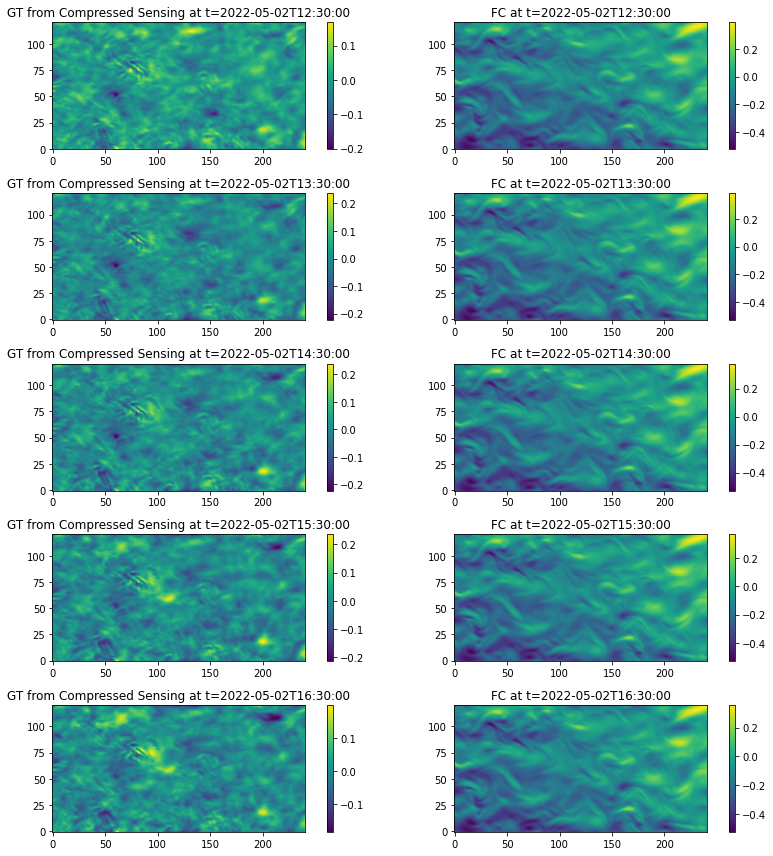

In [10]:
# load CS data
cs_data = xr.load_dataset(os.path.join(save_dir, file_name))

# load forecast
files = sorted(os.listdir(forecast_dir))
fc_data = xr.open_dataset(os.path.join(forecast_dir, files[0])).sel(longitude=slice(-140, -120),latitude=slice(20, 30))

vis_reconstructed_and_forecast(cs_data, fc_data)

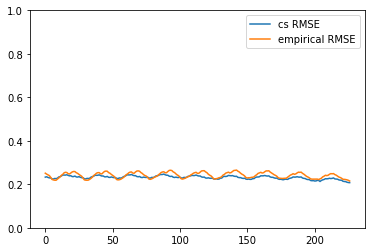

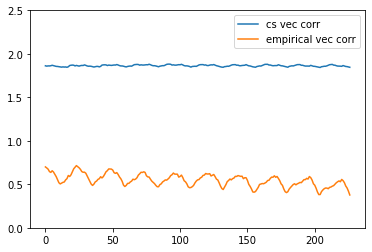

In [4]:
from ocean_navigation_simulator.generative_error_model.generative_model_metrics import rmse_over_time_xr, rmse_over_time, vector_correlation, vector_correlation_over_time

data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data"
fc_dir = os.path.join(data_dir, "forecasts/area1")
cs_dir = os.path.join(data_dir, "cs_data/area1_200")
buoy_dir = os.path.join(data_dir, "dataset_forecast_error/area1")

# get files names
cs_files = sorted(os.listdir(cs_dir))
fc_files = sorted(os.listdir(fc_dir))
buoy_files = sorted(os.listdir(buoy_dir))

cs_rmse = []
empirical_rmse = []
cs_vec_corr = []
empirical_vec_corr = []
for i in range(len(cs_files)):
    cs_data = xr.load_dataset(os.path.join(cs_dir, cs_files[i]))
    fc_data = xr.load_dataset(os.path.join(fc_dir, fc_files[i]))
    buoy_data = pd.read_csv(os.path.join(buoy_dir, buoy_files[i]))

    # rename fc axes
    fc_data = fc_data.rename({"longitude": "lon",
                                "latitude": "lat"})

    # convert data type of cs
    cs_data["lon"] = cs_data["lon"].astype(np.float32)
    cs_data["lat"] = cs_data["lat"].astype(np.float32)
    cs_data["utotal"] = cs_data["utotal"].astype(np.float32)
    cs_data["vtotal"] = cs_data["vtotal"].astype(np.float32)

    # need to slice forecast to match size of error
    lon_range = [cs_data["lon"].values.min(), cs_data["lon"].values.max()]
    lat_range = [cs_data["lat"].values.min(), cs_data["lat"].values.max()]
    time_range = [cs_data["time"].values.min(), cs_data["time"].values.max()]
    fc_data = fc_data.sel(lon=slice(*lon_range),
                            lat=slice(*lat_range),
                            time=slice(*time_range))

    # cs reconstruction errors
    cs_error = fc_data - cs_data
    cs_rmse.append(rmse_over_time_xr(cs_error, variables=("utotal", "vtotal")))

    # empirical errors
    empirical_rmse.append(rmse_over_time(buoy_data, variables=("u_error", "v_error"))["rmse"])

    # cs vec corr
    cs_error_and_fc = fc_data + cs_error
    temp_cs_vec_corr = []
    for time in cs_data["time"]:
        gt_utotal = cs_error_and_fc["utotal"].sel(time=time).values.squeeze()
        gt_vtotal = cs_error_and_fc["vtotal"].sel(time=time).values.squeeze()
        fc_u_error = fc_data["utotal"].sel(time=time).values.squeeze()
        fc_v_error = fc_data["vtotal"].sel(time=time).values.squeeze()
        temp_cs_vec_corr.append(vector_correlation(gt_utotal, gt_vtotal, fc_u_error, fc_v_error))
    cs_vec_corr.append(temp_cs_vec_corr)

    # empirical vec corr
    empirical_vec_corr.append(vector_correlation_over_time(buoy_data))


cs_rmse = np.array(cs_rmse).mean(axis=0)
empirical_rmse = np.array(empirical_rmse).mean(axis=0)
cs_vec_corr = np.array(cs_vec_corr).mean(axis=0)
empirical_vec_corr = np.array(empirical_vec_corr).mean(axis=0)

fig = plt.figure()
plt.plot(cs_rmse, label="cs RMSE")
plt.plot(empirical_rmse, label="empirical RMSE")
plt.ylim([0, 1])
plt.legend()

fig2 = plt.figure()
plt.plot(cs_vec_corr, label="cs vec corr")
plt.plot(empirical_vec_corr, label="empirical vec corr")
plt.ylim([0, 2.5])
plt.legend()
plt.show()

## Load synthetic CS data and sample sparsely to construct variogram

In [24]:
from ocean_navigation_simulator.generative_error_model.variogram.utils import sample_from_xr

data_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data"
cs_dir = os.path.join(data_dir, "cs_data/area1")
fc_dir = os.path.join(data_dir, "forecasts/area1")
save_dir = os.path.join(data_dir, "cs_data/sparse_samples")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

cs_files = sorted(os.listdir(cs_dir))[:10]
fc_files = sorted(os.listdir(fc_dir))[:len(cs_files)]

for cs_file, fc_file in zip(cs_files, fc_files):
    # load data
    fc_data = xr.open_dataset(os.path.join(fc_dir, fc_file))
    cs_data = xr.open_dataset(os.path.join(cs_dir, cs_file))
    # rename fc axes
    fc_data = fc_data.rename({"longitude": "lon",
                                "latitude": "lat"})

    # convert data type of cs
    cs_data["lon"] = cs_data["lon"].astype(np.float32)
    cs_data["lat"] = cs_data["lat"].astype(np.float32)
    cs_data["utotal"] = cs_data["utotal"].astype(np.float32)
    cs_data["vtotal"] = cs_data["vtotal"].astype(np.float32)

    # need to slice forecast to match size of error
    lon_range = [cs_data["lon"].values.min(), cs_data["lon"].values.max()]
    lat_range = [cs_data["lat"].values.min(), cs_data["lat"].values.max()]
    time_range = [cs_data["time"].values.min(), cs_data["time"].values.max()]
    fc_data = fc_data.sel(lon=slice(*lon_range),
                            lat=slice(*lat_range),
                            time=slice(*time_range))

    # get errors, sample and save to save_dir
    error = fc_data - cs_data
    sparse_data = sample_from_xr(error, num_samples=30000, variables=("utotal", "vtotal"))
    sparse_data.to_csv(os.path.join(save_dir, f"{cs_file.split('.')[0]}.csv"))


Loaded variogram from: 2022-09-22_19:26:38_2d_cs_variogram_sparse_samples_[5.0, 1.0]_False_True.npy.
Resolution: [5.0, 1.0] km.
Number of pairs: 44999850000.


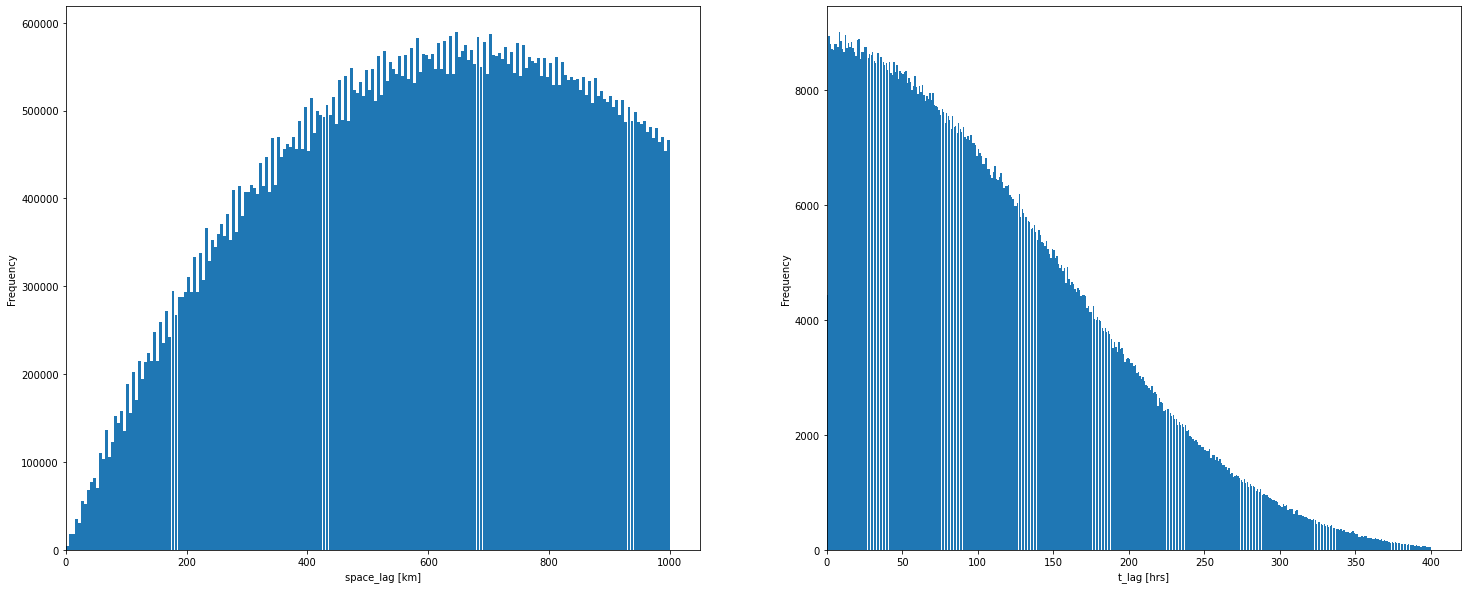

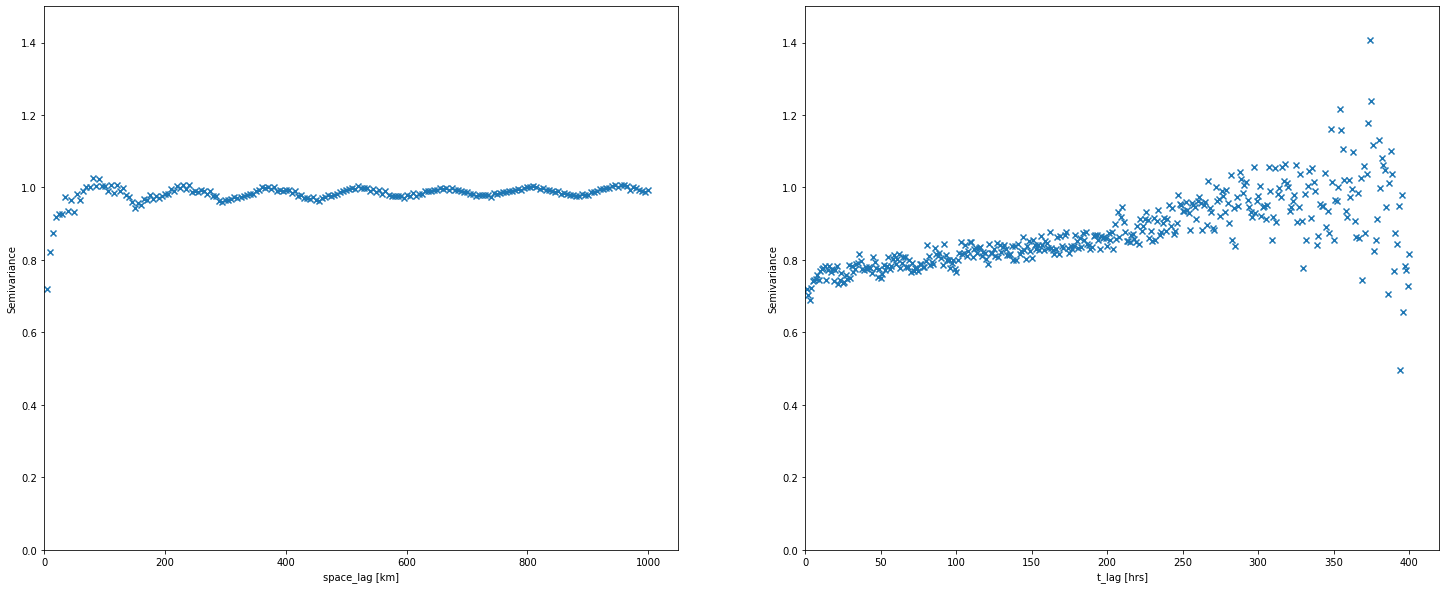

In [6]:
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram

variogram_file = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/cs_data/2022-09-22_19:26:38_2d_cs_variogram_sparse_samples_[5.0, 1.0]_False_True.npy"
vvis = VisualizeVariogram()
vvis.read_variogram_from_file(variogram_file)
vvis.decrease_variogram_res((5, 1))
view_range = [1000, 400]
vvis.plot_histograms(view_range=view_range)
vvis.plot_variograms(view_range=view_range)

## Try CS with Fourier Basis

In [ ]:
from ocean_navigation_simulator.generative_error_model.compressed_sensing.CompressedSensing import round_to_multiple

from scipy.fftpack import dct, idct
import cvxpy as cp
import matplotlib.pyplot as plt
from cosamp.cosamp import cosamp
import numpy as np
import os
import pandas as pd

# load sparse measurements
buoy_dir = "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1"
# buoy_dir = "/home/remote_jonas/OceanPlatformControl/data/drifter_data/dataset_forecast_error/area1"

file_name = sorted(os.listdir(buoy_dir))[0]
buoy_data = pd.read_csv(os.path.join(buoy_dir, file_name))

# add hour column to buoy_data
buoy_data["hour"] = buoy_data["time"].apply(lambda x: x[:13])
hours = sorted(set(buoy_data["hour"].tolist()))
buoy_data_at_time_step = buoy_data[buoy_data["hour"] == hours[0]]

# get nearest grid point
points = np.array([
    buoy_data_at_time_step["lon"],
    buoy_data_at_time_step["lat"]
])
nearest_grid_points = round_to_multiple(points)

# get idx in lon and lat
lon_idx = np.searchsorted(np.arange(-140, -120, 1/12), nearest_grid_points[0])
lat_idx = np.searchsorted(np.arange(20, 30, 1/12), nearest_grid_points[1])

# get idx of points for flattened area
flattened_idx = np.array([lat * np.array(np.arange(-140, -120, 1/12)).shape[0] + lon for lon, lat in zip(lon_idx, lat_idx)])

y = buoy_data_at_time_step["u_error"]   # measurements
n = 241 * 121
w = np.exp(-2j*np.pi/n)
J, K = np.meshgrid(np.arange(n), np.arange(n))
Psi = np.power(w, J*K)
Psi = np.real(Psi)
# Psi = dct(np.eye(241*121), axis=0, norm="ortho")
Theta = Psi[flattened_idx, :]

# # cosamp
# s = cosamp(Theta, y, 10)
# reconstr = idct(s, axis=0, norm="ortho")
# plt.imshow(reconstr, origin="lower")
# plt.show()

# cvx
vx = cp.Variable(Theta.shape[-1])
objective = cp.Minimize(cp.norm(vx, 1))
constraints = [Theta @ vx == y]
prob = cp.Problem(objective, constraints)
prob.solve()

if prob.status in ["infeasible", "unbounded"]:
    print(f"Problem is {prob.status}.")
    raise RuntimeError("Optimization failed and coefficients are None!")
basis_coeffs = np.array(vx.value)

# reconstr = idct(np.eye(241*121), axis=0, norm="ortho") @ basis_coeffs
reconstr = Psi @ basis_coeffs
reconstr = reconstr.reshape((121, 241))

plt.imshow(reconstr, origin="lower")
plt.show()

In [ ]:
# from scipy.fftpack import dct, dst
# fourier_basis = dct(np.eye(256), axis=0, norm="ortho") # + dst(np.eye(256), axis=0, norm="ortho")
# fourier_basis = fourier_basis

n = 241 * 121
w = np.exp(-2j*np.pi/n)
J, K = np.meshgrid(np.arange(n), np.arange(n))
fourier_basis = np.power(w, J*K)
fourier_basis = np.real(fourier_basis)

fig = plt.figure(figsize=(12, 12))
img = plt.imshow(fourier_basis)
plt.colorbar(img)
plt.show()